In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**Blended Scores**

In [ ]:
mode='prod'
#mode='test'
sample=0.005

https://nbviewer.org/github/amaiya/ktrain/blob/master/tutorials/tutorial-A3-hugging_face_transformers.ipynb

In [ ]:
! ls /kaggle/input/ktrain-library/ktrain

!pip install facenet-pytorch --no-index --find-links=file:///kaggle/input/facenet_pytorch/ 

In [ ]:
!pip install ktrain --no-index --find-links=file:///kaggle/input/ktrain-library/ktrain

In [ ]:
#!pip install ktrain

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
import tensorflow as tf

In [ ]:
import seaborn as sns

In [ ]:
import ktrain

In [ ]:
from ktrain import text

Load training dataset

In [ ]:
#df=pd.read_csv("/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip")
#df=pd.read_csv("/kaggle/input/d/julian3833/jigsaw-toxic-comment-classification-challenge/train.csv")
#/kaggle/input/d/julian3833/jigsaw-toxic-comment-classification-challenge/sample_submission.csv
#/kaggle/input/d/julian3833/jigsaw-toxic-comment-classification-challenge/test_labels.csv

#/kaggle/input/d/julian3833/jigsaw-toxic-comment-classification-challenge/test.csv

df=pd.read_csv("../input/jigsaw-toxic-coomens-annotations/jigsaw_train_hate_annotationprob.csv",index_col=0)
if mode=='test':
    df=df.sample(frac=sample)

In [ ]:
df.head()

Load evaluation dataset

In [ ]:
df_valid=pd.read_csv("/kaggle/input/jigsaw-toxic-severity-rating/validation_data.csv",index_col=0)
if mode=='test':
    df_valid=df_valid.sample(frac=sample)

Load comments to score

In [ ]:
comments_to_score=pd.read_csv("/kaggle/input/jigsaw-toxic-severity-rating/comments_to_score.csv",index_col=0)
if mode=='test':
    comments_to_score=comments_to_score.sample(frac=sample)

Main Corpus

scoring

Adjusting scores

In [ ]:
def to_numeric_class(x):
    if x=='neutral':
        return 0
    elif x=='offensive':
        return 1
    else:
        return 2
def offensive_mask(x):
    if x=='neutral':
        return 0
    elif x=='offensive':
        return 1
    else:
        return 0
def hate_mask(x):
    if x=='neutral':
        return 0
    elif x=='offensive':
        return 0
    else:
        return 2
def adjust_score(x):
    if x>0:
        return x+2
    else:
        return x
def adjust_score2(x):
    if x>0.32:
        return x+2
    else:
        return x
def neutral_mask(x):
    if x >0.55 :
        return 1
    else:
        return 0

Regression wrapper

In [ ]:
df.head()

In [ ]:
w1,w2,w3,w4,w5,w6=[0.32, 1.5, 0.16, 1.5, 0.64, 1.5]
#w1,w2,w3,w4,w5,w6=[0.48841081, 0.21194874, 0.39584097, 0.40030452, 0.46899059, 0.42384744]
df['score']=w1*df['toxic']+w2*df['severe_toxic']+w3*df['obscene']+w4*df['threat']+w5*df['insult']+w6*df['identity_hate']

In [ ]:
df['score']=df['score'].apply(lambda x: adjust_score2(x))

In [ ]:
#df['score']=df['score']+1-df['neutral_speech_agreement']
df['score']=df['score']+1-df['neutral_speech_agreement']+df['offensive_agreement_rating']+df['hate_speech_agreement']

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.25)
#test, valid = train_test_split(test, test_size=0.05)

In [ ]:
#train
x_train =train.text.values
y_train = train.score.values
x_test = test.text.values
y_test = test.score.values
#validation
X_less_toxic =df_valid.less_toxic.values
X_more_toxic =df_valid.more_toxic.values
#submit file
X_comments_to_score =comments_to_score.text.values

In [ ]:
!mkdir /root/ktrain_data

In [ ]:
cp -v ../input/fasttext-pretrainedvectors-english-text/cc.en.300.vec  /root/ktrain_data/

In [ ]:
trn, val, preproc = text.texts_from_array(x_train=x_train, y_train=y_train,
                                          x_test=x_test, y_test=y_test,
                                          ngram_range=1, 
                                          maxlen=300, 
                                          max_features=50000)

In [ ]:
model = text.text_regression_model('bigru', train_data=trn, preproc=preproc)
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=32)

In [ ]:
#learner.autofit(4e-4, 8)
learner.autofit(5e-5, 16)

In [ ]:
learner.plot('loss')

In [ ]:
#learner.autofit(2e-4, 6)

In [ ]:
#learner.plot('loss')

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [ ]:
p1 = predictor.predict(X_less_toxic)
p2 = predictor.predict(X_more_toxic)
# Validation Accuracy
(p1 < p2).mean()

Output preds from model 1

In [ ]:
comments_to_score_preds1=predictor.predict(X_comments_to_score)

In [ ]:
#MODEL_NAME = 'distilbert-base-uncased'
#MODEL_NAME = 'roberta-base'
MODEL_NAME = '../input/huggingface-bert/bert-base-uncased/'
t = text.Transformer(MODEL_NAME, maxlen=200)
trn = t.preprocess_train(x_train, y_train)
val = t.preprocess_test(x_test, y_test)

In [ ]:
model = t.get_regression_model()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=24)

In [ ]:
learner.fit_onecycle(5e-5, 3)


In [ ]:
learner.plot('loss')

In [ ]:
predictor2 = ktrain.get_predictor(learner.model, preproc=t)

In [ ]:
predictor2.batch_size = 196

In [ ]:
p3 = predictor2.predict(X_less_toxic)
p4 = predictor2.predict(X_more_toxic)
# Validation Accuracy
(p3 < p4).mean()

In [ ]:
comments_to_score_preds2=predictor2.predict(X_comments_to_score)

In [ ]:
# import os 
# def fname_from_url(url):
#     return os.path.split(url)[-1]
# BERT_URL = 'https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip'
# bert_url = BERT_URL
# bert_path = os.path.join( "ktrain_data", os.path.splitext(fname_from_url(bert_url))[0] )

In [ ]:
# !mkdir /root/ktrain_data/uncased_L-12_H-768_A-12

In [ ]:
# import shutil

In [ ]:
# shutil.copy("../input/huggingface-bert/bert-base-uncased/config.json", "/root/ktrain_data/uncased_L-12_H-768_A-12/config.json")

In [ ]:
# shutil.copy("../input/huggingface-bert/bert-base-uncased/config.json", "/root/ktrain_data/uncased_L-12_H-768_A-12/config.json")
# shutil.copy("../input/huggingface-bert/bert-base-uncased/modelcard.json", "/root/ktrain_data/uncased_L-12_H-768_A-12/modelcard.json")
# shutil.copy("../input/huggingface-bert/bert-base-uncased/pytorch_model.bin", "/root/ktrain_data/uncased_L-12_H-768_A-12/pytorch_model.bin")
# shutil.copy("../input/huggingface-bert/bert-base-uncased/rust_model.ot", "/root/ktrain_data/uncased_L-12_H-768_A-12/rust_model.ot")
# shutil.copy("../input/huggingface-bert/bert-base-uncased/tf_model.h5", "/root/ktrain_data/uncased_L-12_H-768_A-12/tf_model.h5")
# shutil.copy("../input/huggingface-bert/bert-base-uncased/tokenizer.json", "/root/ktrain_data/uncased_L-12_H-768_A-12/tokenizer.json")
# shutil.copy("../input/huggingface-bert/bert-base-uncased/vocab.txt", "/root/ktrain_data/uncased_L-12_H-768_A-12/vocab.txt")

In [ ]:
# bert_path

Bert classification

In [ ]:
df.head(2)

In [ ]:
df.columns

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.25)
#test, valid = train_test_split(test, test_size=0.05)


In [ ]:
#train
x_train =train.text.values
x_test = test.text.values

#validation

In [ ]:
y_train=train.loc[:,"toxic":"identity_hate"]
y_train=y_train.values.tolist()
y_test=test.loc[:,"toxic":"identity_hate"]
y_test=y_test.values.tolist()

In [ ]:
class_names=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult','identity_hate']

In [ ]:
#MODEL_NAME = 'distilbert-base-uncased'
MODEL_NAME = '../input/huggingface-bert/bert-base-uncased/'
#MODEL_NAME = '../input/roberta-base/'
t = text.Transformer(MODEL_NAME, maxlen=230,class_names=class_names)
trn = t.preprocess_train(x_train, y_train)
val = t.preprocess_test(x_test, y_test)

In [ ]:
label_columns = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

In [ ]:
# (x_train, y_train), (x_test, y_test), preproc1 = text.texts_from_df(df, 
#                                                                    'text', # name of column containing review text
#                                                                    label_columns=label_columns,
#                                                                    maxlen=175, 
#                                                                    max_features=100000,
#                                                                    preprocess_mode='bert',
#                                                                    ngram_range=1,
#                                                                    val_pct=0.2)

In [ ]:
#MODEL_NAME = '../input/huggingface-bert/bert-base-uncased/'

In [ ]:
bert_model=t.get_classifier()

https://github.com/amaiya/ktrain/blob/master/FAQ.md

* import ktrain
* from ktrain import text
* t = text.Transformer('/tmp/my_model_files', maxlen=500, class_names=label_list)
* trn = t.preprocess_train(x_train, y_train)
* model = t.get_classifier()
* learner = ktrain.get_learner(model, train_data=trn, batch_size=8)
* learner.fit_onecycle(5e-5, 1)

In [ ]:
bert_learner = ktrain.get_learner(bert_model, train_data=trn, val_data=val,batch_size=8)
#learner.fit_onecycle(5e-5, 2)

Aproximative lr finder not very accurate if you limit the number of epoch

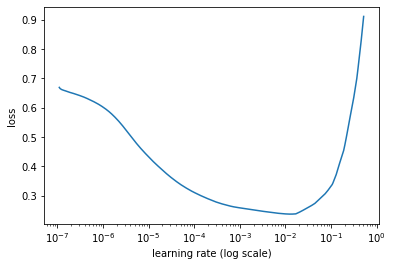

In [ ]:
# define a custom callback for ROC-AUC
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import roc_auc_score
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))
RocAuc = RocAucEvaluation(validation_data=(x_test, y_test), interval=1)

In [ ]:
# train
bert_learner.autofit(4e-5, 3)

In [ ]:
bert_learner.plot('loss')

In [ ]:
bert_predictor = ktrain.get_predictor(bert_learner.model, preproc=t)

In [ ]:
def scoring_preds2(X_less_toxic):
    label_columns = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
    less_toxic_df=pd.DataFrame()
    left_toxic=bert_predictor.predict_proba(X_less_toxic)
    less_toxic_df['preds']=left_toxic.tolist()
    temp_df=pd.DataFrame(less_toxic_df['preds'].to_list(), columns=label_columns)
    less_toxic_df['toxic']=temp_df['toxic']
    less_toxic_df['severe_toxic']=temp_df['severe_toxic']
    less_toxic_df['obscene']=temp_df['obscene']
    less_toxic_df['threat']=temp_df['threat']
    less_toxic_df['insult']=temp_df['insult']
    less_toxic_df['identity_hate']=temp_df['identity_hate']
    less_toxic_df['neutral_mask']=less_toxic_df['toxic'].apply(lambda x: neutral_mask(x))
    w1,w2,w3,w4,w5,w6=[0.32, 1.5, 0.16, 1.5, 0.64, 1.5]
    # #w1,w2,w3,w4,w5,w6=[0.48841081, 0.21194874, 0.39584097, 0.40030452, 0.46899059, 0.42384744]
    less_toxic_df['score']=w1*less_toxic_df['toxic']+w2*less_toxic_df['severe_toxic']+w3*less_toxic_df['obscene']+w4*less_toxic_df['threat']+w5*less_toxic_df['insult']+w6*less_toxic_df['identity_hate']
    #w1,w2,w3,w4,w5,w6=[0.32, 1.5, 0.16, 1.5, 0.64, 1.5]
    w1,w2,w3,w4,w5,w6=[1, 1, 1, 1, 1, 1]
    less_toxic_df['score2']=w1*less_toxic_df['toxic']+w2*less_toxic_df['severe_toxic']+w3*less_toxic_df['obscene']+w4*less_toxic_df['threat']+w5*less_toxic_df['insult']+w6*less_toxic_df['identity_hate']
    #w1,w2,w3,w4,w5,w6=[0.32, 1.5, 0.16, 1.5, 0.64, 1.5]
    w1,w2,w3,w4,w5,w6=[0.48841081, 0.21194874, 0.39584097, 0.40030452, 0.46899059, 0.42384744]
    less_toxic_df['score3']=w1*less_toxic_df['toxic']+w2*less_toxic_df['severe_toxic']+w3*less_toxic_df['obscene']+w4*less_toxic_df['threat']+w5*less_toxic_df['insult']+w6*less_toxic_df['identity_hate']
    #less_toxic_df['score']= less_toxic_df['neutral_mask']*less_toxic_df['score']+less_toxic_df['toxic']
    return less_toxic_df

In [ ]:
less_toxic2= scoring_preds2(X_less_toxic)
more_toxic2= scoring_preds2(X_more_toxic)

p3=less_toxic2['score'].values
p4=more_toxic2['score'].values
(p3 < p4).mean()

In [ ]:
p5=less_toxic2['score2'].values
p6=more_toxic2['score2'].values
(p3 < p4).mean()

In [ ]:
p5=less_toxic2['score3'].values
p6=more_toxic2['score3'].values
(p3 < p4).mean()

In [ ]:
comments_to_score_df=scoring_preds2(X_comments_to_score)

In [ ]:
comments_to_score_preds3=comments_to_score_df['score'].values

Create a Text Regression Model and Wrap in Learner

Type of methods available
fasttext: a fastText-like model [http://arxiv.org/pdf/1607.01759.pdf]
linreg: linear text regression using a trainable Embedding layer
bigru: Bidirectional GRU with pretrained English word vectors [https://arxiv.org/abs/1712.09405]
standard_gru: simple 2-layer GRU with randomly initialized embeddings
bert: Bidirectional Encoder Representations from Transformers (BERT) - keras_bert implementation [https://arxiv.org/abs/1810.04805]
distilbert: distilled, smaller, and faster BERT from Hugging Face transformers [https://arxiv.org/abs/1910.01108]

Prepare the vector . Internet is not available so there is a need for an workaround. 

Bigru

**STEP 5: Making Predictions**

Let's make a prediction for a random text in the validation set.

Using bert for regression

Using the Transfomer API for Text Regression
ktrain includes a simplified interface to the Hugging Face transformers library. This interface can also be used for text regression. Here is a short example of training a BERT model for a single epoch to predict text likes.

Using the Transfomer API for Text Regression

Evaluation using validation_data.csv

Verificare interna.

In [ ]:
from scipy.stats import rankdata

In [ ]:
comments_to_score['score1']=comments_to_score_preds1
comments_to_score['score2']=comments_to_score_preds2
comments_to_score['score3']=comments_to_score_preds3

In [ ]:
comments_to_score['rank1']=rankdata( comments_to_score['score1'], method='ordinal')
comments_to_score['rank2']=rankdata( comments_to_score['score2'], method='ordinal')
comments_to_score['rank3']=rankdata( comments_to_score['score3'], method='ordinal')
a1,a2,a3=[1,2,2]
comments_to_score['blended_rank']=(a1*comments_to_score['rank1']+a2*comments_to_score['rank2']+a3*comments_to_score['rank3'])/5
comments_to_score['score']=rankdata( comments_to_score['blended_rank'], method='ordinal')

Testare

In [ ]:
#comments_to_score['score']=predicted_scores

In [ ]:
#submission=comments_to_score[['score']]
#submission=comments_to_score[['blended_rank']]
# submission=comments_to_score[['rank2']]
#comments_to_score['score']=comments_to_score['score2']
submission=comments_to_score[['score']]

In [ ]:
comments_to_score.head()

In [ ]:
submission.to_csv('submission.csv')

In [ ]:
submission.head()